Install necessary packages. Pip has ! in front because it is a command line tool

In [1]:
#!pip install os
#!pip install numpy
#!pip install time
#!pip install tensorflow-gpu
#!pip install statistics

Import packages

In [1]:
import os
import numpy as np
import time
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import statistics

Check which version of tensorflow, set seed, get number of gpu in system

In [3]:
print(tf.__version__)
np.random.seed(975008430)
tf.random.set_seed(975008430)
tf.config.list_physical_devices('GPU')

2.7.0


[]

Import data to use in the nn



In [4]:

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
# see what train_images looks like
print(train_images)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


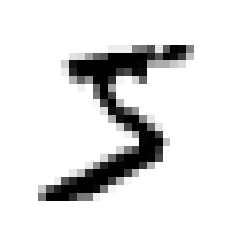

5

In [6]:
some_digit = train_images[0]
plt.imshow(some_digit, cmap="binary")
plt.axis("off")
plt.show()
train_labels[0]

See what the data look like because it will need to be scaled and/or converted to one hot encoding. From above print(tf.shape(train_images)) and print(tf.shape(test_images)) we know these are [60000, 28, 28] and [10000, 28, 28] respectively but need to be [60000, 784] and [10000, 784] respectively

In [7]:
#normalize X
train_images = train_images/255.0
test_images = test_images/255.0
# reshape train and test images (input data)
train_images = train_images.reshape(train_images.shape[0],28*28)
test_images = test_images.reshape(test_images.shape[0],28*28)

# one hot encoding of train and test labels (output)
train_labels = tf.one_hot(train_labels,10)
test_labels = tf.one_hot(test_labels,10)

Preparing the data to use in the mlp

In [8]:
from tensorflow.python.ops.gen_array_ops import size
# data
# (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
# Input layer, tensor (seen in chunk above) is shape [x, 28*28]
size_input = 28*28
size_first_hidden = 256
size_second_hidden = 256
size_output = 10
number_of_train_examples = train_images.shape[0]
number_of_test_examples = test_images.shape[0]

# train and test sets

X_train = train_images
y_train = train_labels
X_test = test_images
y_test = test_labels

## last 10000 training for validation
# images
X_train, X_validation = X_train[:-10000], X_train[-10000:]
# labels
y_train, y_validation = y_train[:-10000], y_train[-10000:]

Quick look at what X_train and y_train look like to make sure nothing went wrong when reshaping

In [9]:
print(X_train)
print(tf.shape(X_train))
print(y_train)
print(tf.shape(test_labels))
print(tf.shape(test_images))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
tf.Tensor([50000   784], shape=(2,), dtype=int32)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]], shape=(50000, 10), dtype=float32)
tf.Tensor([10000    10], shape=(2,), dtype=int32)
tf.Tensor([10000   784], shape=(2,), dtype=int32)


In [10]:
# split into batches
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).batch(16) # although this gets redone in training...
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)

Build MLP model. this one has no regularization

In [11]:
# define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_first_hidden, size_second_hidden, size_output, device=None):
    '''
    size_input: int, size of input layer
    size_first_hidden: int, size of first hidden layer
    size_second_hidden: int, size of second hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    '''
    self.size_input, self.size_first_hidden, self.size_second_hidden, self.size_output, self.device =\
    size_input, size_first_hidden, size_second_hidden, size_output, device

    # initialize weights between input layer and first hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_first_hidden]))
    # initialize weights between first hidden layer and second hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_first_hidden, self.size_second_hidden]))
    # initialize weights between second hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_second_hidden, self.size_output]))
    # initialise biases for first hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_first_hidden]))
    # initialise biases for second hidden layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_second_hidden]))
    # initialise biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))

    # define variables to be updated during backprop
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
  
  # forward pass
  def forward(self, X):
    '''
    forward pass
    X: Tensor, inputs
    '''
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
    
    return self.y
  
  #loss function. cross entropy
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    return tf.nn.softmax_cross_entropy_with_logits(y_true_tf, y_pred_tf)
    #scce = tf.keras.losses.SparseCategoricalCrossentropy()
    #temp = scce(y_true_tf, y_pred_tf).numpy()
    #print(temp)
    #return scce(y_true_tf, y_pred_tf).numpy()
  
  # backward pass
  def backward(self, X_train, y_train):
    '''
    backward pass
    '''
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    
    grads = tape.gradient(current_loss, self.variables)
    #print(type(grads))
    #lr = 1e-4
    #dws = grads
    #dws_new = [i * lr for i in dws]
    #print(type(dws[0:1]))
    #Wt = [a_i - b_i for a_i, b_i in zip(self.variables, dws_new)]
    #W = self.variables[0]
    #W.assign(Wt[0])
    #W1 = self.variables[1]
    #W1.assign(Wt[1])
    #W2 = self.variables[2]
    #W2.assign(Wt[2])
    #B = self.variables[3]
    #B.assign(Wt[3])
    #B1 = self.variables[4]
    #B1.assign(Wt[4])
    #B2 = self.variables[5]
    #B2.assign(Wt[5])
    #return grads
    optimizer.apply_gradients(zip(grads, self.variables))
  
  def vanillasgd(self, grads, lr = 1e-4):
    '''
    one-step of sgd to update weights
    '''
    print(self.variables[0])
    print(grads[3:4])

    self.variables[0] = self.variables[0] - tf.math.scalar_mul(lr,dws[0,1])
    self.variables[1] = self.variables[1] - lr*grads[1,2]
    self.variables[2] = self.variables[2] - lr*grads[2,3]
    self.variables[3] = self.variables[3] - lr*grads[3,4]
    self.variables[4] = self.variables[4] - lr*grads[4,5]
    self.variables[5] = self.variables[5] - lr*grads[5,6]
  
  # compute output
  def compute_output(self, X):
    '''
    obtain output tensor during forward pass
    '''
    # cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    # remember to normalize dataset before moving forward
    # compute values in first hidden layer
    # softmax for multiclass classification
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)
    # compute values in second hidden layer
    w2hat = tf.matmul(hhat, self.W2) + self.b2
    h2hat = tf.nn.relu(w2hat)
    # compute output
    output = tf.matmul(h2hat, self.W3) + self.b3
    output_softmax = tf.nn.softmax(output)
    return output_softmax




Train model with validation

In [12]:
# Set number of epochs
NUM_EPOCHS = 10
# save results into here to plot
train_loss_results = []
train_accuracy_results = []
val_loss_results = []
val_accuracy_results = []
train_mse_results = []
val_mse_results = []

# Initialize model using GPU
mlp_on_gpu = MLP(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlp_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlp_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  train_loss_results.append(np.sum(loss_total_gpu) / X_train.shape[0])
  train_accuracy_results.append(accuracy_train.result())
  val_loss_results.append(np.sum(val_loss_total)/ X_train.shape[0])
  val_accuracy_results.append(accuracy_val.result())
  train_mse_results.append(np.sum(mse_train))
  val_mse_results.append(np.sum(mse_val))
    #correct_prediction_val = tf.math.equal(tf.argmax(y_validation,1), tf.argmax(preds_val,1))
    #accuracy_val = tf.reduce_mean(tf.cast(correct_prediction_val, tf.float32))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  #print('Training Accuracy = {:.5f}'.format(np.sum(accuracy_train)/ X_train.shape[0]))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
  #print('Validation Accuracy = {:.5f}'.format(np.sum(accuracy_val)/ X_train.shape[0])
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Average Training Loss (CE) = 2.29429, Training Accuracy 0.827500
Average Validation Loss (CE) = 0.47186, Validation Accuracy = 0.80500
Number of Epoch = 2 - Average Training Loss (CE) = 2.26847, Training Accuracy 0.828750
Average Validation Loss (CE) = 0.47241, Validation Accuracy = 0.80875
Number of Epoch = 3 - Average Training Loss (CE) = 2.25303, Training Accuracy 0.840000
Average Validation Loss (CE) = 0.47229, Validation Accuracy = 0.80875
Number of Epoch = 4 - Average Training Loss (CE) = 2.23281, Training Accuracy 0.838750
Average Validation Loss (CE) = 0.47200, Validation Accuracy = 0.79625
Number of Epoch = 5 - Average Training Loss (CE) = 2.20796, Training Accuracy 0.850000
Average Validation Loss (CE) = 0.47179, Validation Accuracy = 0.81625
Number of Epoch = 6 - Average Training Loss (CE) = 2.18145, Training Accuracy 0.855000
Average Validation Loss (CE) = 0.47154, Validation Accuracy = 0.81625
Number of Epoch = 7 - Average Training Loss (CE) = 2.15968

Test model

In [13]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
test_ds_outputs = []
test_ds_trues = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_gpu.loss(preds, outputs)
  accuracy_test = tf.keras.metrics.Accuracy()
  accuracy_test.update_state(preds, outputs)
  accuracy_test.result().numpy()
  test_ds_outputs.append(outputs)
  test_ds_trues.append(y_test)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(test_loss_total) / X_train.shape[0], accuracy_test.result().numpy()))

Test CE Loss = 0.42297, Test Accuracy = 0.88750


Plotting training and validation 
Loss and Accuracy

In [14]:
#from google.colab import files

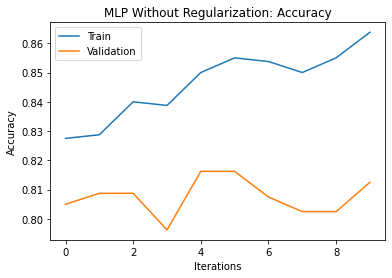

In [15]:
iterations = list(range(NUM_EPOCHS))
plt.plot(iterations, train_accuracy_results, label = 'Train')
plt.plot(iterations, val_accuracy_results, label = 'Validation')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('MLP Without Regularization: Accuracy')
plt.legend(loc='upper left')
plt.show()
#plt.savefig('mlp_noreg_acc.png')
#files.download('mlp_noreg_acc.png')


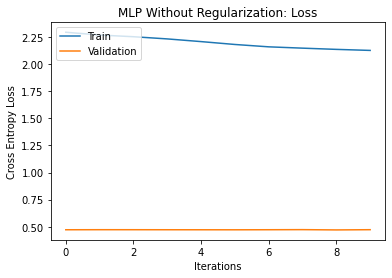

In [16]:
iterations = list(range(NUM_EPOCHS))
plt.plot(iterations, train_loss_results, label = 'Train')
plt.plot(iterations, val_loss_results, label = 'Validation')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iterations')
plt.title('MLP Without Regularization: Loss')
plt.legend(loc='upper left')
plt.show()
#plt.savefig('mlp_noreg_loss.png')
#files.download('mlp_noreg_loss.png')

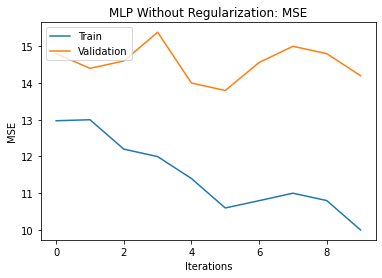

In [17]:
iterations = list(range(NUM_EPOCHS))
plt.plot(iterations, train_mse_results, label = 'Train')
plt.plot(iterations, val_mse_results, label = 'Validation')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.title('MLP Without Regularization: MSE')
plt.legend(loc='upper left')
plt.show()

Redoing the model with L2 regularization: 

In [18]:
from tensorflow.python.ops.gen_nn_ops import l2_loss
# defint class to build mlp model
class MLPl2(object):
  def __init__(self, size_input, size_first_hidden, size_second_hidden, size_output, device=None):
    '''
    size_input: int, size of input layer
    size_first_hidden: int, size of first hidden layer
    size_second_hidden: int, size of second hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    '''
    self.size_input, self.size_first_hidden, self.size_second_hidden, self.size_output, self.device =\
    size_input, size_first_hidden, size_second_hidden, size_output, device

    # initialize weights between input layer and first hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_first_hidden]))
    # initialize weights between first hidden layer and second hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_first_hidden, self.size_second_hidden]))
    # initialize weights between second hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_second_hidden, self.size_output]))
    # initialise biases for first hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_first_hidden]))
    # initialise biases for second hidden layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_second_hidden]))
    # initialise biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))

    # define variables to be updated during backprop
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
  
  # forward pass
  def forward(self, X):
    '''
    forward pass
    X: Tensor, inputs
    '''
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
    
    return self.y
  
  #loss function. cross entropy
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    return (tf.reduce_mean(.9 * tf.nn.softmax_cross_entropy_with_logits(y_true_tf, y_pred_tf)) +
     .1 * tf.nn.l2_loss(self.W1) +
     .1 * tf.nn.l2_loss(self.W2) +
     .1 * tf.nn.l2_loss(self.W3))
    #scce = tf.keras.losses.SparseCategoricalCrossentropy()
    #temp = scce(y_true_tf, y_pred_tf).numpy()
    #print(temp)
    #return scce(y_true_tf, y_pred_tf).numpy() 
  
  # backward pass
  def backward(self, X_train, y_train):
    '''
    backward pass
    '''
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
  
  def vanillasgd(self, grads, lr = 1e-4):
    '''
    one-step of sgd to update weights
    '''
    print(self.variables[0])
    print(grads[3:4])

    self.variables[0] = self.variables[0] - tf.math.scalar_mul(lr,dws[0,1])
    self.variables[1] = self.variables[1] - lr*grads[1,2]
    self.variables[2] = self.variables[2] - lr*grads[2,3]
    self.variables[3] = self.variables[3] - lr*grads[3,4]
    self.variables[4] = self.variables[4] - lr*grads[4,5]
    self.variables[5] = self.variables[5] - lr*grads[5,6]
  
  # compute output
  def compute_output(self, X):
    '''
    obtain output tensor during forward pass
    '''
    # cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    # remember to normalize dataset before moving forward
    # compute values in first hidden layer
    # softmax for multiclass classification
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)
    # compute values in second hidden layer
    w2hat = tf.matmul(hhat, self.W2) + self.b2
    h2hat = tf.nn.relu(w2hat)
    # compute output
    output = tf.matmul(h2hat, self.W3) + self.b3
    output_softmax = tf.nn.softmax(output)
    return output_softmax

In [19]:
# Set number of epochs
NUM_EPOCHS = 10
# save results into here to plot
l2train_loss_results = []
l2train_accuracy_results = []
l2val_loss_results = []
l2val_accuracy_results = []
l2train_mse_results = []
l2val_mse_results = []

# Initialize model using GPU
mlpl2_on_gpu = MLPl2(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl2_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl2_on_gpu.loss(preds, outputs)
    lt = lt + mlpl2_on_gpu.loss(preds, outputs)
    mlpl2_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl2_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl2_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l2train_loss_results.append(np.sum(loss_total_gpu)/ X_train.shape[0])
  l2train_accuracy_results.append(accuracy_train.result())
  l2val_loss_results.append(np.sum(val_loss_total)/ X_train.shape[0])
  l2val_accuracy_results.append(accuracy_val.result())
  l2train_mse_results.append(np.sum(mse_train))
  l2val_mse_results.append(np.sum(mse_val))
    #correct_prediction_val = tf.math.equal(tf.argmax(y_validation,1), tf.argmax(preds_val,1))
    #accuracy_val = tf.reduce_mean(tf.cast(correct_prediction_val, tf.float32))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu)/ X_train.shape[0], accuracy_train.result().numpy()))
  #print('Training Accuracy = {:.5f}'.format(np.sum(accuracy_train)/ X_train.shape[0]))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
  #print('Validation Accuracy = {:.5f}'.format(np.sum(accuracy_val)/ X_train.shape[0])
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Average Training Loss (CE) = 167.46934, Training Accuracy 0.810000
Average Validation Loss (CE) = 33.28461, Validation Accuracy = 0.82250
Number of Epoch = 2 - Average Training Loss (CE) = 165.38937, Training Accuracy 0.813750
Average Validation Loss (CE) = 32.87123, Validation Accuracy = 0.81500
Number of Epoch = 3 - Average Training Loss (CE) = 163.33526, Training Accuracy 0.812500
Average Validation Loss (CE) = 32.46293, Validation Accuracy = 0.81000
Number of Epoch = 4 - Average Training Loss (CE) = 161.30659, Training Accuracy 0.813750
Average Validation Loss (CE) = 32.05974, Validation Accuracy = 0.81250
Number of Epoch = 5 - Average Training Loss (CE) = 159.30313, Training Accuracy 0.810000
Average Validation Loss (CE) = 31.66156, Validation Accuracy = 0.80875
Number of Epoch = 6 - Average Training Loss (CE) = 157.32458, Training Accuracy 0.810000
Average Validation Loss (CE) = 31.26835, Validation Accuracy = 0.81500
Number of Epoch = 7 - Average Training L

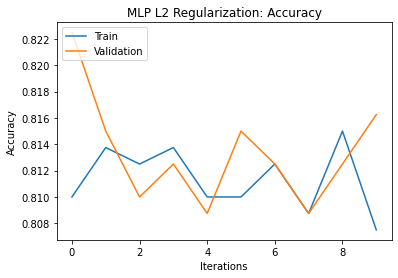

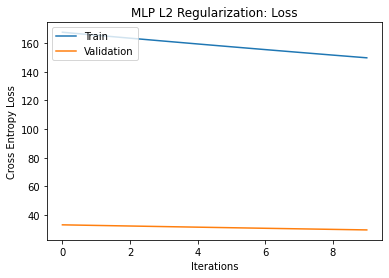

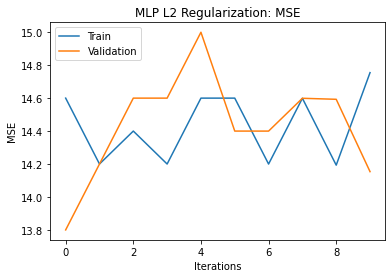

In [20]:
iterations = list(range(NUM_EPOCHS))
plt.plot(iterations, l2train_accuracy_results, label = 'Train')
plt.plot(iterations, l2val_accuracy_results, label = 'Validation')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('MLP L2 Regularization: Accuracy')
plt.legend(loc='upper left')
plt.show()
#plt.savefig('mlp_noreg_acc.png')
#files.download('mlp_noreg_acc.png')


iterations = list(range(NUM_EPOCHS))
plt.plot(iterations, l2train_loss_results, label = 'Train')
plt.plot(iterations, l2val_loss_results, label = 'Validation')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iterations')
plt.title('MLP L2 Regularization: Loss')
plt.legend(loc='upper left')
plt.show()

iterations = list(range(NUM_EPOCHS))
plt.plot(iterations, l2train_mse_results, label = 'Train')
plt.plot(iterations, l2val_mse_results, label = 'Validation')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.title('MLP L2 Regularization: MSE')
plt.legend(loc='upper left')
plt.show()


In [21]:
l2test_loss_total = tf.Variable(0, dtype=tf.float32)
l2test_ds_outputs = []
l2test_ds_trues = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl2_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l2test_loss_total = l2test_loss_total + mlpl2_on_gpu.loss(preds, outputs)
  l2accuracy_test = tf.keras.metrics.Accuracy()
  l2accuracy_test.update_state(preds, outputs)
  l2accuracy_test.result().numpy()
  l2test_ds_outputs.append(outputs)
  l2test_ds_trues.append(y_test)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l2test_loss_total) / X_train.shape[0], l2accuracy_test.result().numpy()))

Test CE Loss = 148.71856, Test Accuracy = 0.78750


L1 regularization

In [22]:
from tensorflow.python.ops.gen_nn_ops import l2_loss
# defint class to build mlp model
class MLPl1(object):
  def __init__(self, size_input, size_first_hidden, size_second_hidden, size_output, device=None):
    '''
    size_input: int, size of input layer
    size_first_hidden: int, size of first hidden layer
    size_second_hidden: int, size of second hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    '''
    self.size_input, self.size_first_hidden, self.size_second_hidden, self.size_output, self.device =\
    size_input, size_first_hidden, size_second_hidden, size_output, device

    # initialize weights between input layer and first hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_first_hidden]))
    # initialize weights between first hidden layer and second hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_first_hidden, self.size_second_hidden]))
    # initialize weights between second hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_second_hidden, self.size_output]))
    # initialise biases for first hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_first_hidden]))
    # initialise biases for second hidden layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_second_hidden]))
    # initialise biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))

    # define variables to be updated during backprop
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
  
  # forward pass
  def forward(self, X):
    '''
    forward pass
    X: Tensor, inputs
    '''
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
    
    return self.y
  
  #loss function. cross entropy
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    return (tf.reduce_mean(.9 * tf.nn.softmax_cross_entropy_with_logits(y_true_tf, y_pred_tf)) +
            .1 * tf.math.reduce_sum(np.abs(self.W1)) +
            .1 * tf.math.reduce_sum(np.abs(self.W2)) +
            .1 * tf.math.reduce_sum(np.abs(self.W3)))
    #scce = tf.keras.losses.SparseCategoricalCrossentropy()
    #temp = scce(y_true_tf, y_pred_tf).numpy()
    #print(temp)
    #return scce(y_true_tf, y_pred_tf).numpy() 
  
  # backward pass
  def backward(self, X_train, y_train):
    '''
    backward pass
    '''
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
  
  def vanillasgd(self, grads, lr = 1e-4):
    '''
    one-step of sgd to update weights
    '''
    print(self.variables[0])
    print(grads[3:4])

    self.variables[0] = self.variables[0] - tf.math.scalar_mul(lr,dws[0,1])
    self.variables[1] = self.variables[1] - lr*grads[1,2]
    self.variables[2] = self.variables[2] - lr*grads[2,3]
    self.variables[3] = self.variables[3] - lr*grads[3,4]
    self.variables[4] = self.variables[4] - lr*grads[4,5]
    self.variables[5] = self.variables[5] - lr*grads[5,6]
  
  # compute output
  def compute_output(self, X):
    '''
    obtain output tensor during forward pass
    '''
    # cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    # remember to normalize dataset before moving forward
    # compute values in first hidden layer
    # softmax for multiclass classification
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)
    # compute values in second hidden layer
    w2hat = tf.matmul(hhat, self.W2) + self.b2
    h2hat = tf.nn.relu(w2hat)
    # compute output
    output = tf.matmul(h2hat, self.W3) + self.b3
    output_softmax = tf.nn.softmax(output)
    return output_softmax

Train model w/ validation

In [23]:
# Set number of epochs
NUM_EPOCHS = 10
# save results into here to plot
l1train_loss_results = []
l1train_accuracy_results = []
l1val_loss_results = []
l1val_accuracy_results = []
l1train_mse_results = []
l1val_mse_results = []

# Initialize model using GPU
mlpl1_on_gpu = MLPl1(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl1_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl1_on_gpu.loss(preds, outputs)
    lt = lt + mlpl1_on_gpu.loss(preds, outputs)
    mlpl1_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl1_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl1_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l1train_loss_results.append(np.sum(loss_total_gpu) / X_train.shape[0])
  l1train_accuracy_results.append(accuracy_train.result())
  l1val_loss_results.append(np.sum(val_loss_total)/ X_train.shape[0])
  l1val_accuracy_results.append(accuracy_val.result())
  l1train_mse_results.append(np.sum(mse_train)/ X_train.shape[0])
  l1val_mse_results.append(np.sum(mse_val)/ X_train.shape[0])
    #correct_prediction_val = tf.math.equal(tf.argmax(y_validation,1), tf.argmax(preds_val,1))
    #accuracy_val = tf.reduce_mean(tf.cast(correct_prediction_val, tf.float32))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  #print('Training Accuracy = {:.5f}'.format(np.sum(accuracy_train)/ X_train.shape[0]))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
  #print('Validation Accuracy = {:.5f}'.format(np.sum(accuracy_val)/ X_train.shape[0])
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Average Training Loss (CE) = 268.09700, Training Accuracy 0.805000
Average Validation Loss (CE) = 53.61928, Validation Accuracy = 0.80875
Number of Epoch = 2 - Average Training Loss (CE) = 268.09706, Training Accuracy 0.802500
Average Validation Loss (CE) = 53.61930, Validation Accuracy = 0.79250
Number of Epoch = 3 - Average Training Loss (CE) = 268.09704, Training Accuracy 0.802500
Average Validation Loss (CE) = 53.61928, Validation Accuracy = 0.80625


KeyboardInterrupt: ignored

In [ ]:
l1test_loss_total = tf.Variable(0, dtype=tf.float32)
l1test_ds_outputs = []
l1test_ds_trues = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl1_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l1test_loss_total = l1test_loss_total + mlpl1_on_gpu.loss(preds, outputs)
  l1accuracy_test = tf.keras.metrics.Accuracy()
  l1accuracy_test.update_state(preds, outputs)
  l1accuracy_test.result().numpy()
  l1test_ds_outputs.append(outputs)
  l1test_ds_trues.append(y_test)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l1test_loss_total) / X_train.shape[0], l1accuracy_test.result().numpy()))

In [ ]:
iterations = list(range(NUM_EPOCHS))
plt.plot(iterations, l1train_accuracy_results, label = 'Train')
plt.plot(iterations, l1val_accuracy_results, label = 'Validation')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('MLP L1 Regularization: Accuracy')
plt.legend(loc='upper left')
plt.show()
#plt.savefig('mlp_noreg_acc.png')
#files.download('mlp_noreg_acc.png')


iterations = list(range(NUM_EPOCHS))
plt.plot(iterations, l1train_loss_results, label = 'Train')
plt.plot(iterations, l1val_loss_results, label = 'Validation')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iterations')
plt.title('MLP L1 Regularization: Loss')
plt.legend(loc='upper left')
plt.show()

iterations = list(range(NUM_EPOCHS))
plt.plot(iterations, l1train_mse_results, label = 'Train')
plt.plot(iterations, l1val_mse_results, label = 'Validation')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.title('MLP L1 Regularization: MSE')
plt.legend(loc='upper left')
plt.show()

Now run each (no regularization, L1, and L2) nine more times each for a total of 10 each. Different seeds for different results each time. MLP models is already defined above so it does not need to be redefined. Retrain with validation and rerun test, resave results.

In [ ]:
np.random.seed(975008431)
tf.random.set_seed(975008431)
# Set number of epochs
NUM_EPOCHS = 10

No regularization 2

In [ ]:
# save results into here
train_loss_results_2 = []
train_accuracy_results_2 = []
val_loss_results_2 = []
val_accuracy_results_2 = []
train_mse_results_2 = []
val_mse_results_2 = []

# Initialize model using GPU
mlp_on_gpu = MLP(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlp_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlp_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  train_loss_results_2.append(np.sum(loss_total_gpu) / X_train.shape[0])
  train_accuracy_results_2.append(accuracy_train.result())
  val_loss_results_2.append(np.sum(val_loss_total)/ X_train.shape[0])
  val_accuracy_results_2.append(accuracy_val.result())
  train_mse_results_2.append(np.sum(mse_train))
  val_mse_results_2.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
test_loss_total_2 = tf.Variable(0, dtype=tf.float32)
test_ds_outputs_2 = []
test_ds_trues_2 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total_2 = test_loss_total_2 + mlp_on_gpu.loss(preds, outputs)
  accuracy_test_2 = tf.keras.metrics.Accuracy()
  accuracy_test_2.update_state(preds, outputs)
  accuracy_test_2.result().numpy()
  test_ds_outputs_2.append(outputs)
  test_ds_trues_2.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(test_loss_total) / X_train.shape[0], accuracy_test.result().numpy()))

L2 2

In [ ]:
# save results into here to plot
l2train_loss_results_2 = []
l2train_accuracy_results_2 = []
l2val_loss_results_2 = []
l2val_accuracy_results_2 = []
l2train_mse_results_2 = []
l2val_mse_results_2 = []

# Initialize model using GPU
mlpl2_on_gpu = MLPl2(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl2_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl2_on_gpu.loss(preds, outputs)
    lt = lt + mlpl2_on_gpu.loss(preds, outputs)
    mlpl2_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl2_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl2_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l2train_loss_results_2.append(np.sum(loss_total_gpu)/ X_train.shape[0])
  l2train_accuracy_results_2.append(accuracy_train.result())
  l2val_loss_results_2.append(np.sum(val_loss_total)/ X_train.shape[0])
  l2val_accuracy_results_2.append(accuracy_val.result())
  l2train_mse_results_2.append(np.sum(mse_train))
  l2val_mse_results_2.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu)/ X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l2test_loss_total_2 = tf.Variable(0, dtype=tf.float32)
l2test_ds_outputs_2 = []
l2test_ds_trues_2 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl2_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l2test_loss_total_2 = l2test_loss_total_2 + mlpl2_on_gpu.loss(preds, outputs)
  l2accuracy_test_2 = tf.keras.metrics.Accuracy()
  l2accuracy_test_2.update_state(preds, outputs)
  l2accuracy_test_2.result().numpy()
  l2test_ds_outputs_2.append(outputs)
  l2test_ds_trues_2.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l2test_loss_total) / X_train.shape[0], l2accuracy_test.result().numpy()))

L1 2

In [ ]:
# save results into here
l1train_loss_results_2 = []
l1train_accuracy_results_2 = []
l1val_loss_results_2 = []
l1val_accuracy_results_2 = []
l1train_mse_results_2 = []
l1val_mse_results_2 = []

# Initialize model using GPU
mlpl1_on_gpu = MLPl1(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl1_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl1_on_gpu.loss(preds, outputs)
    lt = lt + mlpl1_on_gpu.loss(preds, outputs)
    mlpl1_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl1_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl1_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l1train_loss_results_2.append(np.sum(loss_total_gpu) / X_train.shape[0])
  l1train_accuracy_results_2.append(accuracy_train.result())
  l1val_loss_results_2.append(np.sum(val_loss_total)/ X_train.shape[0])
  l1val_accuracy_results_2.append(accuracy_val.result())
  l1train_mse_results_2.append(np.sum(mse_train)/ X_train.shape[0])
  l1val_mse_results_2.append(np.sum(mse_val)/ X_train.shape[0])
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l1test_loss_total_2 = tf.Variable(0, dtype=tf.float32)
l1test_ds_outputs_2 = []
l1test_ds_trues_2 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl1_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l1test_loss_total_2 = l1test_loss_total_2 + mlpl1_on_gpu.loss(preds, outputs)
  l1accuracy_test_2 = tf.keras.metrics.Accuracy()
  l1accuracy_test_2.update_state(preds, outputs)
  l1accuracy_test_2.result().numpy()
  l1test_ds_outputs_2.append(outputs)
  l1test_ds_trues_2.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l1test_loss_total) / X_train.shape[0], l1accuracy_test.result().numpy()))

In [ ]:
np.random.seed(975008432)
tf.random.set_seed(975008432)

No regularization 3

In [ ]:
# save results into here
train_loss_results_3 = []
train_accuracy_results_3 = []
val_loss_results_3 = []
val_accuracy_results_3 = []
train_mse_results_3 = []
val_mse_results_3 = []

# Initialize model using GPU
mlp_on_gpu = MLP(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlp_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlp_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  train_loss_results_3.append(np.sum(loss_total_gpu) / X_train.shape[0])
  train_accuracy_results_3.append(accuracy_train.result())
  val_loss_results_3.append(np.sum(val_loss_total)/ X_train.shape[0])
  val_accuracy_results_3.append(accuracy_val.result())
  train_mse_results_3.append(np.sum(mse_train))
  val_mse_results_3.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
test_loss_total_3 = tf.Variable(0, dtype=tf.float32)
test_ds_outputs_3 = []
test_ds_trues_3 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total_3 = test_loss_total_3 + mlp_on_gpu.loss(preds, outputs)
  accuracy_test_3 = tf.keras.metrics.Accuracy()
  accuracy_test_3.update_state(preds, outputs)
  accuracy_test_3.result().numpy()
  test_ds_outputs_3.append(outputs)
  test_ds_trues_3.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(test_loss_total) / X_train.shape[0], accuracy_test.result().numpy()))

L2 3

In [ ]:
# save results into here to plot
l2train_loss_results_3 = []
l2train_accuracy_results_3 = []
l2val_loss_results_3 = []
l2val_accuracy_results_3 = []
l2train_mse_results_3 = []
l2val_mse_results_3 = []

# Initialize model using GPU
mlpl2_on_gpu = MLPl2(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl2_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl2_on_gpu.loss(preds, outputs)
    lt = lt + mlpl2_on_gpu.loss(preds, outputs)
    mlpl2_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl2_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl2_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l2train_loss_results_3.append(np.sum(loss_total_gpu)/ X_train.shape[0])
  l2train_accuracy_results_3.append(accuracy_train.result())
  l2val_loss_results_3.append(np.sum(val_loss_total)/ X_train.shape[0])
  l2val_accuracy_results_3.append(accuracy_val.result())
  l2train_mse_results_3.append(np.sum(mse_train))
  l2val_mse_results_3.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu)/ X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l2test_loss_total_3 = tf.Variable(0, dtype=tf.float32)
l2test_ds_outputs_3 = []
l2test_ds_trues_3 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl2_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l2test_loss_total_3 = l2test_loss_total_3 + mlpl2_on_gpu.loss(preds, outputs)
  l2accuracy_test_3 = tf.keras.metrics.Accuracy()
  l2accuracy_test_3.update_state(preds, outputs)
  l2accuracy_test_3.result().numpy()
  l2test_ds_outputs_3.append(outputs)
  l2test_ds_trues_3.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l2test_loss_total) / X_train.shape[0], l2accuracy_test.result().numpy()))

L1 3

In [ ]:
# save results into here
l1train_loss_results_3 = []
l1train_accuracy_results_3 = []
l1val_loss_results_3 = []
l1val_accuracy_results_3 = []
l1train_mse_results_3 = []
l1val_mse_results_3 = []

# Initialize model using GPU
mlpl1_on_gpu = MLPl1(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl1_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl1_on_gpu.loss(preds, outputs)
    lt = lt + mlpl1_on_gpu.loss(preds, outputs)
    mlpl1_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl1_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl1_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l1train_loss_results_3.append(np.sum(loss_total_gpu) / X_train.shape[0])
  l1train_accuracy_results_3.append(accuracy_train.result())
  l1val_loss_results_3.append(np.sum(val_loss_total)/ X_train.shape[0])
  l1val_accuracy_results_3.append(accuracy_val.result())
  l1train_mse_results_3.append(np.sum(mse_train)/ X_train.shape[0])
  l1val_mse_results_3.append(np.sum(mse_val)/ X_train.shape[0])
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l1test_loss_total_3 = tf.Variable(0, dtype=tf.float32)
l1test_ds_outputs_3 = []
l1test_ds_trues_3 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl1_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l1test_loss_total_3 = l1test_loss_total_3 + mlpl1_on_gpu.loss(preds, outputs)
  l1accuracy_test_3 = tf.keras.metrics.Accuracy()
  l1accuracy_test_3.update_state(preds, outputs)
  l1accuracy_test_3.result().numpy()
  l1test_ds_outputs_3.append(outputs)
  l1test_ds_trues_3.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l1test_loss_total) / X_train.shape[0], l1accuracy_test.result().numpy()))

In [ ]:
np.random.seed(975008433)
tf.random.set_seed(975008433)

No regularization 4

In [ ]:
# save results into here
train_loss_results_4 = []
train_accuracy_results_4 = []
val_loss_results_4 = []
val_accuracy_results_4 = []
train_mse_results_4 = []
val_mse_results_4 = []

# Initialize model using GPU
mlp_on_gpu = MLP(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlp_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlp_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  train_loss_results_4.append(np.sum(loss_total_gpu) / X_train.shape[0])
  train_accuracy_results_4.append(accuracy_train.result())
  val_loss_results_4.append(np.sum(val_loss_total)/ X_train.shape[0])
  val_accuracy_results_4.append(accuracy_val.result())
  train_mse_results_4.append(np.sum(mse_train))
  val_mse_results_4.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
test_loss_total_4 = tf.Variable(0, dtype=tf.float32)
test_ds_outputs_4 = []
test_ds_trues_4 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total_4 = test_loss_total_4 + mlp_on_gpu.loss(preds, outputs)
  accuracy_test_4 = tf.keras.metrics.Accuracy()
  accuracy_test_4.update_state(preds, outputs)
  accuracy_test_4.result().numpy()
  test_ds_outputs_4.append(outputs)
  test_ds_trues_4.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(test_loss_total) / X_train.shape[0], accuracy_test.result().numpy()))

L2 4

In [ ]:
# save results into here to plot
l2train_loss_results_4 = []
l2train_accuracy_results_4 = []
l2val_loss_results_4 = []
l2val_accuracy_results_4 = []
l2train_mse_results_4 = []
l2val_mse_results_4 = []

# Initialize model using GPU
mlpl2_on_gpu = MLPl2(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl2_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl2_on_gpu.loss(preds, outputs)
    lt = lt + mlpl2_on_gpu.loss(preds, outputs)
    mlpl2_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl2_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl2_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l2train_loss_results_4.append(np.sum(loss_total_gpu)/ X_train.shape[0])
  l2train_accuracy_results_4.append(accuracy_train.result())
  l2val_loss_results_4.append(np.sum(val_loss_total)/ X_train.shape[0])
  l2val_accuracy_results_4.append(accuracy_val.result())
  l2train_mse_results_4.append(np.sum(mse_train))
  l2val_mse_results_4.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu)/ X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l2test_loss_total_4 = tf.Variable(0, dtype=tf.float32)
l2test_ds_outputs_4 = []
l2test_ds_trues_4 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl2_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l2test_loss_total_4 = l2test_loss_total_4 + mlpl2_on_gpu.loss(preds, outputs)
  l2accuracy_test_4 = tf.keras.metrics.Accuracy()
  l2accuracy_test_4.update_state(preds, outputs)
  l2accuracy_test_4.result().numpy()
  l2test_ds_outputs_4.append(outputs)
  l2test_ds_trues_4.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l2test_loss_total) / X_train.shape[0], l2accuracy_test.result().numpy()))

L1 4

In [ ]:
# save results into here
l1train_loss_results_4 = []
l1train_accuracy_results_4 = []
l1val_loss_results_4 = []
l1val_accuracy_results_4 = []
l1train_mse_results_4 = []
l1val_mse_results_4 = []

# Initialize model using GPU
mlpl1_on_gpu = MLPl1(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl1_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl1_on_gpu.loss(preds, outputs)
    lt = lt + mlpl1_on_gpu.loss(preds, outputs)
    mlpl1_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl1_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl1_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l1train_loss_results_4.append(np.sum(loss_total_gpu) / X_train.shape[0])
  l1train_accuracy_results_4.append(accuracy_train.result())
  l1val_loss_results_4.append(np.sum(val_loss_total)/ X_train.shape[0])
  l1val_accuracy_results_4.append(accuracy_val.result())
  l1train_mse_results_4.append(np.sum(mse_train)/ X_train.shape[0])
  l1val_mse_results_4.append(np.sum(mse_val)/ X_train.shape[0])
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l1test_loss_total_4 = tf.Variable(0, dtype=tf.float32)
l1test_ds_outputs_4 = []
l1test_ds_trues_4 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl1_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l1test_loss_total_4 = l1test_loss_total_4 + mlpl1_on_gpu.loss(preds, outputs)
  l1accuracy_test_4 = tf.keras.metrics.Accuracy()
  l1accuracy_test_4.update_state(preds, outputs)
  l1accuracy_test_4.result().numpy()
  l1test_ds_outputs_4.append(outputs)
  l1test_ds_trues_4.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l1test_loss_total) / X_train.shape[0], l1accuracy_test.result().numpy()))

In [ ]:
np.random.seed(975008434)
tf.random.set_seed(975008434)

No regularization 5

In [ ]:
# save results into here
train_loss_results_5 = []
train_accuracy_results_5 = []
val_loss_results_5 = []
val_accuracy_results_5 = []
train_mse_results_5 = []
val_mse_results_5 = []

# Initialize model using GPU
mlp_on_gpu = MLP(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlp_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlp_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  train_loss_results_5.append(np.sum(loss_total_gpu) / X_train.shape[0])
  train_accuracy_results_5.append(accuracy_train.result())
  val_loss_results_5.append(np.sum(val_loss_total)/ X_train.shape[0])
  val_accuracy_results_5.append(accuracy_val.result())
  train_mse_results_5.append(np.sum(mse_train))
  val_mse_results_5.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
test_loss_total_5 = tf.Variable(0, dtype=tf.float32)
test_ds_outputs_5 = []
test_ds_trues_5 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total_5 = test_loss_total_5 + mlp_on_gpu.loss(preds, outputs)
  accuracy_test_5 = tf.keras.metrics.Accuracy()
  accuracy_test_5.update_state(preds, outputs)
  accuracy_test_5.result().numpy()
  test_ds_outputs_5.append(outputs)
  test_ds_trues_5.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(test_loss_total) / X_train.shape[0], accuracy_test.result().numpy()))

L2 5

In [ ]:
# save results into here to plot
l2train_loss_results_5 = []
l2train_accuracy_results_5 = []
l2val_loss_results_5 = []
l2val_accuracy_results_5 = []
l2train_mse_results_5 = []
l2val_mse_results_5 = []

# Initialize model using GPU
mlpl2_on_gpu = MLPl2(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl2_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl2_on_gpu.loss(preds, outputs)
    lt = lt + mlpl2_on_gpu.loss(preds, outputs)
    mlpl2_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl2_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl2_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l2train_loss_results_5.append(np.sum(loss_total_gpu)/ X_train.shape[0])
  l2train_accuracy_results_5.append(accuracy_train.result())
  l2val_loss_results_5.append(np.sum(val_loss_total)/ X_train.shape[0])
  l2val_accuracy_results_5.append(accuracy_val.result())
  l2train_mse_results_5.append(np.sum(mse_train))
  l2val_mse_results_5.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu)/ X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l2test_loss_total_5 = tf.Variable(0, dtype=tf.float32)
l2test_ds_outputs_5 = []
l2test_ds_trues_5 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl2_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l2test_loss_total_5 = l2test_loss_total_5 + mlpl2_on_gpu.loss(preds, outputs)
  l2accuracy_test_5 = tf.keras.metrics.Accuracy()
  l2accuracy_test_5.update_state(preds, outputs)
  l2accuracy_test_5.result().numpy()
  l2test_ds_outputs_5.append(outputs)
  l2test_ds_trues_5.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l2test_loss_total) / X_train.shape[0], l2accuracy_test.result().numpy()))

L1 5

In [ ]:
# save results into here
l1train_loss_results_5 = []
l1train_accuracy_results_5 = []
l1val_loss_results_5 = []
l1val_accuracy_results_5 = []
l1train_mse_results_5 = []
l1val_mse_results_5 = []

# Initialize model using GPU
mlpl1_on_gpu = MLPl1(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl1_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl1_on_gpu.loss(preds, outputs)
    lt = lt + mlpl1_on_gpu.loss(preds, outputs)
    mlpl1_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl1_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl1_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l1train_loss_results_5.append(np.sum(loss_total_gpu) / X_train.shape[0])
  l1train_accuracy_results_5.append(accuracy_train.result())
  l1val_loss_results_5.append(np.sum(val_loss_total)/ X_train.shape[0])
  l1val_accuracy_results_5.append(accuracy_val.result())
  l1train_mse_results_5.append(np.sum(mse_train)/ X_train.shape[0])
  l1val_mse_results_5.append(np.sum(mse_val)/ X_train.shape[0])
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l1test_loss_total_5 = tf.Variable(0, dtype=tf.float32)
l1test_ds_outputs_5 = []
l1test_ds_trues_5 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl1_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l1test_loss_total_5 = l1test_loss_total_5 + mlpl1_on_gpu.loss(preds, outputs)
  l1accuracy_test_5 = tf.keras.metrics.Accuracy()
  l1accuracy_test_5.update_state(preds, outputs)
  l1accuracy_test_5.result().numpy()
  l1test_ds_outputs_5.append(outputs)
  l1test_ds_trues_5.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l1test_loss_total) / X_train.shape[0], l1accuracy_test.result().numpy()))

In [ ]:
np.random.seed(975008435)
tf.random.set_seed(975008435)

No regularization 6

In [ ]:
# save results into here
train_loss_results_6 = []
train_accuracy_results_6 = []
val_loss_results_6 = []
val_accuracy_results_6 = []
train_mse_results_6 = []
val_mse_results_6 = []

# Initialize model using GPU
mlp_on_gpu = MLP(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlp_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlp_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  train_loss_results_6.append(np.sum(loss_total_gpu) / X_train.shape[0])
  train_accuracy_results_6.append(accuracy_train.result())
  val_loss_results_6.append(np.sum(val_loss_total)/ X_train.shape[0])
  val_accuracy_results_6.append(accuracy_val.result())
  train_mse_results_6.append(np.sum(mse_train))
  val_mse_results_6.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
test_loss_total_6 = tf.Variable(0, dtype=tf.float32)
test_ds_outputs_6 = []
test_ds_trues_6 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total_6 = test_loss_total_6 + mlp_on_gpu.loss(preds, outputs)
  accuracy_test_6 = tf.keras.metrics.Accuracy()
  accuracy_test_6.update_state(preds, outputs)
  accuracy_test_6.result().numpy()
  test_ds_outputs_6.append(outputs)
  test_ds_trues_6.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(test_loss_total) / X_train.shape[0], accuracy_test.result().numpy()))

L2 6

In [ ]:
# save results into here to plot
l2train_loss_results_6 = []
l2train_accuracy_results_6 = []
l2val_loss_results_6 = []
l2val_accuracy_results_6 = []
l2train_mse_results_6 = []
l2val_mse_results_6 = []

# Initialize model using GPU
mlpl2_on_gpu = MLPl2(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl2_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl2_on_gpu.loss(preds, outputs)
    lt = lt + mlpl2_on_gpu.loss(preds, outputs)
    mlpl2_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl2_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl2_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l2train_loss_results_6.append(np.sum(loss_total_gpu)/ X_train.shape[0])
  l2train_accuracy_results_6.append(accuracy_train.result())
  l2val_loss_results_6.append(np.sum(val_loss_total)/ X_train.shape[0])
  l2val_accuracy_results_6.append(accuracy_val.result())
  l2train_mse_results_6.append(np.sum(mse_train))
  l2val_mse_results_6.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu)/ X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l2test_loss_total_6 = tf.Variable(0, dtype=tf.float32)
l2test_ds_outputs_6 = []
l2test_ds_trues_6 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl2_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l2test_loss_total_6 = l2test_loss_total_6 + mlpl2_on_gpu.loss(preds, outputs)
  l2accuracy_test_6 = tf.keras.metrics.Accuracy()
  l2accuracy_test_6.update_state(preds, outputs)
  l2accuracy_test_6.result().numpy()
  l2test_ds_outputs_6.append(outputs)
  l2test_ds_trues_6.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l2test_loss_total) / X_train.shape[0], l2accuracy_test.result().numpy()))

L1 6

In [ ]:
# save results into here
l1train_loss_results_6 = []
l1train_accuracy_results_6 = []
l1val_loss_results_6 = []
l1val_accuracy_results_6 = []
l1train_mse_results_6 = []
l1val_mse_results_6 = []

# Initialize model using GPU
mlpl1_on_gpu = MLPl1(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl1_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl1_on_gpu.loss(preds, outputs)
    lt = lt + mlpl1_on_gpu.loss(preds, outputs)
    mlpl1_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl1_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl1_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l1train_loss_results_6.append(np.sum(loss_total_gpu) / X_train.shape[0])
  l1train_accuracy_results_6.append(accuracy_train.result())
  l1val_loss_results_6.append(np.sum(val_loss_total)/ X_train.shape[0])
  l1val_accuracy_results_6.append(accuracy_val.result())
  l1train_mse_results_6.append(np.sum(mse_train)/ X_train.shape[0])
  l1val_mse_results_6.append(np.sum(mse_val)/ X_train.shape[0])
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l1test_loss_total_6 = tf.Variable(0, dtype=tf.float32)
l1test_ds_outputs_6 = []
l1test_ds_trues_6 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl1_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l1test_loss_total_6 = l1test_loss_total_6 + mlpl1_on_gpu.loss(preds, outputs)
  l1accuracy_test_6 = tf.keras.metrics.Accuracy()
  l1accuracy_test_6.update_state(preds, outputs)
  l1accuracy_test_6.result().numpy()
  l1test_ds_outputs_6.append(outputs)
  l1test_ds_trues_6.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l1test_loss_total) / X_train.shape[0], l1accuracy_test.result().numpy()))

In [ ]:
np.random.seed(975008436)
tf.random.set_seed(975008436)

No regularization 7

In [ ]:
# save results into here
train_loss_results_7 = []
train_accuracy_results_7 = []
val_loss_results_7 = []
val_accuracy_results_7 = []
train_mse_results_7 = []
val_mse_results_7 = []

# Initialize model using GPU
mlp_on_gpu = MLP(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlp_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlp_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  train_loss_results_7.append(np.sum(loss_total_gpu) / X_train.shape[0])
  train_accuracy_results_7.append(accuracy_train.result())
  val_loss_results_7.append(np.sum(val_loss_total)/ X_train.shape[0])
  val_accuracy_results_7.append(accuracy_val.result())
  train_mse_results_7.append(np.sum(mse_train))
  val_mse_results_7.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
test_loss_total_7 = tf.Variable(0, dtype=tf.float32)
test_ds_outputs_7 = []
test_ds_trues_7 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total_7 = test_loss_total_7 + mlp_on_gpu.loss(preds, outputs)
  accuracy_test_7 = tf.keras.metrics.Accuracy()
  accuracy_test_7.update_state(preds, outputs)
  accuracy_test_7.result().numpy()
  test_ds_outputs_7.append(outputs)
  test_ds_trues_7.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(test_loss_total) / X_train.shape[0], accuracy_test.result().numpy()))

L2 7

In [ ]:
# save results into here to plot
l2train_loss_results_7 = []
l2train_accuracy_results_7 = []
l2val_loss_results_7 = []
l2val_accuracy_results_7 = []
l2train_mse_results_7 = []
l2val_mse_results_7 = []

# Initialize model using GPU
mlpl2_on_gpu = MLPl2(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl2_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl2_on_gpu.loss(preds, outputs)
    lt = lt + mlpl2_on_gpu.loss(preds, outputs)
    mlpl2_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl2_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl2_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l2train_loss_results_7.append(np.sum(loss_total_gpu)/ X_train.shape[0])
  l2train_accuracy_results_7.append(accuracy_train.result())
  l2val_loss_results_7.append(np.sum(val_loss_total)/ X_train.shape[0])
  l2val_accuracy_results_7.append(accuracy_val.result())
  l2train_mse_results_7.append(np.sum(mse_train))
  l2val_mse_results_7.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu)/ X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l2test_loss_total_7 = tf.Variable(0, dtype=tf.float32)
l2test_ds_outputs_7 = []
l2test_ds_trues_7 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl2_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l2test_loss_total_7 = l2test_loss_total_7 + mlpl2_on_gpu.loss(preds, outputs)
  l2accuracy_test_7 = tf.keras.metrics.Accuracy()
  l2accuracy_test_7.update_state(preds, outputs)
  l2accuracy_test_7.result().numpy()
  l2test_ds_outputs_7.append(outputs)
  l2test_ds_trues_7.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l2test_loss_total) / X_train.shape[0], l2accuracy_test.result().numpy()))

L1 7

In [ ]:
# save results into here
l1train_loss_results_7 = []
l1train_accuracy_results_7 = []
l1val_loss_results_7 = []
l1val_accuracy_results_7 = []
l1train_mse_results_7 = []
l1val_mse_results_7 = []

# Initialize model using GPU
mlpl1_on_gpu = MLPl1(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl1_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl1_on_gpu.loss(preds, outputs)
    lt = lt + mlpl1_on_gpu.loss(preds, outputs)
    mlpl1_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl1_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl1_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l1train_loss_results_7.append(np.sum(loss_total_gpu) / X_train.shape[0])
  l1train_accuracy_results_7.append(accuracy_train.result())
  l1val_loss_results_7.append(np.sum(val_loss_total)/ X_train.shape[0])
  l1val_accuracy_results_7.append(accuracy_val.result())
  l1train_mse_results_7.append(np.sum(mse_train)/ X_train.shape[0])
  l1val_mse_results_7.append(np.sum(mse_val)/ X_train.shape[0])
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l1test_loss_total_7 = tf.Variable(0, dtype=tf.float32)
l1test_ds_outputs_7 = []
l1test_ds_trues_7 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl1_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l1test_loss_total_7 = l1test_loss_total_7 + mlpl1_on_gpu.loss(preds, outputs)
  l1accuracy_test_7 = tf.keras.metrics.Accuracy()
  l1accuracy_test_7.update_state(preds, outputs)
  l1accuracy_test_7.result().numpy()
  l1test_ds_outputs_7.append(outputs)
  l1test_ds_trues_7.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l1test_loss_total) / X_train.shape[0], l1accuracy_test.result().numpy()))

In [ ]:
np.random.seed(975008437)
tf.random.set_seed(975008437)

No regularization 8

In [ ]:
# save results into here
train_loss_results_8 = []
train_accuracy_results_8 = []
val_loss_results_8 = []
val_accuracy_results_8 = []
train_mse_results_8 = []
val_mse_results_8 = []

# Initialize model using GPU
mlp_on_gpu = MLP(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlp_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlp_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  train_loss_results_8.append(np.sum(loss_total_gpu) / X_train.shape[0])
  train_accuracy_results_8.append(accuracy_train.result())
  val_loss_results_8.append(np.sum(val_loss_total)/ X_train.shape[0])
  val_accuracy_results_8.append(accuracy_val.result())
  train_mse_results_8.append(np.sum(mse_train))
  val_mse_results_8.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
test_loss_total_8 = tf.Variable(0, dtype=tf.float32)
test_ds_outputs_8 = []
test_ds_trues_8 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total_8 = test_loss_total_8 + mlp_on_gpu.loss(preds, outputs)
  accuracy_test_8 = tf.keras.metrics.Accuracy()
  accuracy_test_8.update_state(preds, outputs)
  accuracy_test_8.result().numpy()
  test_ds_outputs_8.append(outputs)
  test_ds_trues_8.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(test_loss_total) / X_train.shape[0], accuracy_test.result().numpy()))

L2 8

In [ ]:
# save results into here to plot
l2train_loss_results_8 = []
l2train_accuracy_results_8 = []
l2val_loss_results_8 = []
l2val_accuracy_results_8 = []
l2train_mse_results_8 = []
l2val_mse_results_8 = []

# Initialize model using GPU
mlpl2_on_gpu = MLPl2(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl2_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl2_on_gpu.loss(preds, outputs)
    lt = lt + mlpl2_on_gpu.loss(preds, outputs)
    mlpl2_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl2_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl2_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l2train_loss_results_8.append(np.sum(loss_total_gpu)/ X_train.shape[0])
  l2train_accuracy_results_8.append(accuracy_train.result())
  l2val_loss_results_8.append(np.sum(val_loss_total)/ X_train.shape[0])
  l2val_accuracy_results_8.append(accuracy_val.result())
  l2train_mse_results_8.append(np.sum(mse_train))
  l2val_mse_results_8.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu)/ X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l2test_loss_total_8 = tf.Variable(0, dtype=tf.float32)
l2test_ds_outputs_8 = []
l2test_ds_trues_8 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl2_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l2test_loss_total_8 = l2test_loss_total_8 + mlpl2_on_gpu.loss(preds, outputs)
  l2accuracy_test_8 = tf.keras.metrics.Accuracy()
  l2accuracy_test_8.update_state(preds, outputs)
  l2accuracy_test_8.result().numpy()
  l2test_ds_outputs_8.append(outputs)
  l2test_ds_trues_8.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l2test_loss_total) / X_train.shape[0], l2accuracy_test.result().numpy()))

L1 8

In [ ]:
# save results into here
l1train_loss_results_8 = []
l1train_accuracy_results_8 = []
l1val_loss_results_8 = []
l1val_accuracy_results_8 = []
l1train_mse_results_8 = []
l1val_mse_results_8 = []

# Initialize model using GPU
mlpl1_on_gpu = MLPl1(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl1_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl1_on_gpu.loss(preds, outputs)
    lt = lt + mlpl1_on_gpu.loss(preds, outputs)
    mlpl1_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl1_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl1_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l1train_loss_results_8.append(np.sum(loss_total_gpu) / X_train.shape[0])
  l1train_accuracy_results_8.append(accuracy_train.result())
  l1val_loss_results_8.append(np.sum(val_loss_total)/ X_train.shape[0])
  l1val_accuracy_results_8.append(accuracy_val.result())
  l1train_mse_results_8.append(np.sum(mse_train)/ X_train.shape[0])
  l1val_mse_results_8.append(np.sum(mse_val)/ X_train.shape[0])
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l1test_loss_total_8 = tf.Variable(0, dtype=tf.float32)
l1test_ds_outputs_8 = []
l1test_ds_trues_8 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl1_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l1test_loss_total_8 = l1test_loss_total_8 + mlpl1_on_gpu.loss(preds, outputs)
  l1accuracy_test_8 = tf.keras.metrics.Accuracy()
  l1accuracy_test_8.update_state(preds, outputs)
  l1accuracy_test_8.result().numpy()
  l1test_ds_outputs_8.append(outputs)
  l1test_ds_trues_8.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l1test_loss_total) / X_train.shape[0], l1accuracy_test.result().numpy()))

In [ ]:
np.random.seed(975008438)
tf.random.set_seed(975008438)

No regularization 9

In [ ]:
# save results into here
train_loss_results_9 = []
train_accuracy_results_9 = []
val_loss_results_9 = []
val_accuracy_results_9 = []
train_mse_results_9 = []
val_mse_results_9 = []

# Initialize model using GPU
mlp_on_gpu = MLP(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlp_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlp_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  train_loss_results_9.append(np.sum(loss_total_gpu) / X_train.shape[0])
  train_accuracy_results_9.append(accuracy_train.result())
  val_loss_results_9.append(np.sum(val_loss_total)/ X_train.shape[0])
  val_accuracy_results_9.append(accuracy_val.result())
  train_mse_results_9.append(np.sum(mse_train))
  val_mse_results_9.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
test_loss_total_9 = tf.Variable(0, dtype=tf.float32)
test_ds_outputs_9 = []
test_ds_trues_9 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total_9 = test_loss_total_9 + mlp_on_gpu.loss(preds, outputs)
  accuracy_test_9 = tf.keras.metrics.Accuracy()
  accuracy_test_9.update_state(preds, outputs)
  accuracy_test_9.result().numpy()
  test_ds_outputs_9.append(outputs)
  test_ds_trues_9.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(test_loss_total) / X_train.shape[0], accuracy_test.result().numpy()))

L2 9

In [ ]:
# save results into here to plot
l2train_loss_results_9 = []
l2train_accuracy_results_9 = []
l2val_loss_results_9 = []
l2val_accuracy_results_9 = []
l2train_mse_results_9 = []
l2val_mse_results_9 = []

# Initialize model using GPU
mlpl2_on_gpu = MLPl2(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl2_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl2_on_gpu.loss(preds, outputs)
    lt = lt + mlpl2_on_gpu.loss(preds, outputs)
    mlpl2_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl2_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl2_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l2train_loss_results_9.append(np.sum(loss_total_gpu)/ X_train.shape[0])
  l2train_accuracy_results_9.append(accuracy_train.result())
  l2val_loss_results_9.append(np.sum(val_loss_total)/ X_train.shape[0])
  l2val_accuracy_results_9.append(accuracy_val.result())
  l2train_mse_results_9.append(np.sum(mse_train))
  l2val_mse_results_9.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu)/ X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l2test_loss_total_9 = tf.Variable(0, dtype=tf.float32)
l2test_ds_outputs_9 = []
l2test_ds_trues_9 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl2_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l2test_loss_total_9 = l2test_loss_total_4 + mlpl2_on_gpu.loss(preds, outputs)
  l2accuracy_test_9 = tf.keras.metrics.Accuracy()
  l2accuracy_test_9.update_state(preds, outputs)
  l2accuracy_test_9.result().numpy()
  l2test_ds_outputs_9.append(outputs)
  l2test_ds_trues_9.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l2test_loss_total) / X_train.shape[0], l2accuracy_test.result().numpy()))

L1 9

In [ ]:
# save results into here
l1train_loss_results_9 = []
l1train_accuracy_results_9 = []
l1val_loss_results_9 = []
l1val_accuracy_results_9 = []
l1train_mse_results_9 = []
l1val_mse_results_9 = []

# Initialize model using GPU
mlpl1_on_gpu = MLPl1(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl1_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl1_on_gpu.loss(preds, outputs)
    lt = lt + mlpl1_on_gpu.loss(preds, outputs)
    mlpl1_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl1_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl1_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l1train_loss_results_9.append(np.sum(loss_total_gpu) / X_train.shape[0])
  l1train_accuracy_results_9.append(accuracy_train.result())
  l1val_loss_results_9.append(np.sum(val_loss_total)/ X_train.shape[0])
  l1val_accuracy_results_9.append(accuracy_val.result())
  l1train_mse_results_9.append(np.sum(mse_train)/ X_train.shape[0])
  l1val_mse_results_9.append(np.sum(mse_val)/ X_train.shape[0])
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l1test_loss_total_9 = tf.Variable(0, dtype=tf.float32)
l1test_ds_outputs_9 = []
l1test_ds_trues_9 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl1_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l1test_loss_total_9 = l1test_loss_total_9 + mlpl1_on_gpu.loss(preds, outputs)
  l1accuracy_test_9 = tf.keras.metrics.Accuracy()
  l1accuracy_test_9.update_state(preds, outputs)
  l1accuracy_test_9.result().numpy()
  l1test_ds_outputs_9.append(outputs)
  l1test_ds_trues_9.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l1test_loss_total) / X_train.shape[0], l1accuracy_test.result().numpy()))

In [ ]:
np.random.seed(975008439)
tf.random.set_seed(975008439)

No regularization 10

In [ ]:
# save results into here
train_loss_results_10 = []
train_accuracy_results_10 = []
val_loss_results_10 = []
val_accuracy_results_10 = []
train_mse_results_10 = []
val_mse_results_10 = []

# Initialize model using GPU
mlp_on_gpu = MLP(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlp_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlp_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  train_loss_results_10.append(np.sum(loss_total_gpu) / X_train.shape[0])
  train_accuracy_results_10.append(accuracy_train.result())
  val_loss_results_10.append(np.sum(val_loss_total)/ X_train.shape[0])
  val_accuracy_results_10.append(accuracy_val.result())
  train_mse_results_10.append(np.sum(mse_train))
  val_mse_results_10.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
test_loss_total_10 = tf.Variable(0, dtype=tf.float32)
test_ds_outputs_10 = []
test_ds_trues_10 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total_10 = test_loss_total_10 + mlp_on_gpu.loss(preds, outputs)
  accuracy_test_10 = tf.keras.metrics.Accuracy()
  accuracy_test_10.update_state(preds, outputs)
  accuracy_test_10.result().numpy()
  test_ds_outputs_10.append(outputs)
  test_ds_trues_10.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(test_loss_total) / X_train.shape[0], accuracy_test.result().numpy()))

L2 10

In [ ]:
# save results into here to plot
l2train_loss_results_10 = []
l2train_accuracy_results_10 = []
l2val_loss_results_10 = []
l2val_accuracy_results_10 = []
l2train_mse_results_10 = []
l2val_mse_results_10 = []

# Initialize model using GPU
mlpl2_on_gpu = MLPl2(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl2_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl2_on_gpu.loss(preds, outputs)
    lt = lt + mlpl2_on_gpu.loss(preds, outputs)
    mlpl2_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl2_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl2_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l2train_loss_results_10.append(np.sum(loss_total_gpu)/ X_train.shape[0])
  l2train_accuracy_results_10.append(accuracy_train.result())
  l2val_loss_results_10.append(np.sum(val_loss_total)/ X_train.shape[0])
  l2val_accuracy_results_10.append(accuracy_val.result())
  l2train_mse_results_10.append(np.sum(mse_train))
  l2val_mse_results_10.append(np.sum(mse_val))
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu)/ X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l2test_loss_total_10 = tf.Variable(0, dtype=tf.float32)
l2test_ds_outputs_10 = []
l2test_ds_trues_10 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl2_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l2test_loss_total_10 = l2test_loss_total_10 + mlpl2_on_gpu.loss(preds, outputs)
  l2accuracy_test_10 = tf.keras.metrics.Accuracy()
  l2accuracy_test_10.update_state(preds, outputs)
  l2accuracy_test_10.result().numpy()
  l2test_ds_outputs_10.append(outputs)
  l2test_ds_trues_10.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l2test_loss_total) / X_train.shape[0], l2accuracy_test.result().numpy()))

L1 10

In [ ]:
# save results into here
l1train_loss_results_10 = []
l1train_accuracy_results_10 = []
l1val_loss_results_10 = []
l1val_accuracy_results_10 = []
l1train_mse_results_10 = []
l1val_mse_results_10 = []

# Initialize model using GPU
mlpl1_on_gpu = MLPl1(size_input, size_first_hidden, size_second_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for inputs, outputs in train_ds:
    preds = mlpl1_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlpl1_on_gpu.loss(preds, outputs)
    lt = lt + mlpl1_on_gpu.loss(preds, outputs)
    mlpl1_on_gpu.backward(inputs, outputs)
    accuracy_train = tf.keras.metrics.Accuracy()
    accuracy_train.update_state(preds, outputs)
    accuracy_train.result().numpy()
    mse_train = tf.keras.metrics.mean_squared_error(preds, outputs)
  val_loss_total = tf.Variable(0, dtype=tf.float32)
  val_ds = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).shuffle(25, seed=epoch*(975008430)).batch(80)
  for input, outputs in val_ds:
    preds_val = mlpl1_on_gpu.forward(inputs)
    val_loss_total = val_loss_total + mlpl1_on_gpu.loss(preds_val, outputs)
    accuracy_val = tf.keras.metrics.Accuracy()
    accuracy_val.update_state(preds_val, outputs)
    accuracy_val.result().numpy()
    mse_val = tf.keras.metrics.mean_squared_error(preds_val, outputs)
   # End epoch
  l1train_loss_results_10.append(np.sum(loss_total_gpu) / X_train.shape[0])
  l1train_accuracy_results_10.append(accuracy_train.result())
  l1val_loss_results_10.append(np.sum(val_loss_total)/ X_train.shape[0])
  l1val_accuracy_results_10.append(accuracy_val.result())
  l1train_mse_results_10.append(np.sum(mse_train)/ X_train.shape[0])
  l1val_mse_results_10.append(np.sum(mse_val)/ X_train.shape[0])
  print('Number of Epoch = {} - Average Training Loss (CE) = {:.5f}, Training Accuracy {:5f}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], accuracy_train.result().numpy()))
  print('Average Validation Loss (CE) = {:.5f}, Validation Accuracy = {:.5f}'.format(np.sum(val_loss_total)/ X_train.shape[0], accuracy_val.result().numpy()))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

l1test_loss_total_10 = tf.Variable(0, dtype=tf.float32)
l1test_ds_outputs_10 = []
l1test_ds_trues_10 = []
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlpl1_on_gpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  l1test_loss_total_10 = l1test_loss_total_10 + mlpl1_on_gpu.loss(preds, outputs)
  l1accuracy_test_10 = tf.keras.metrics.Accuracy()
  l1accuracy_test_10.update_state(preds, outputs)
  l1accuracy_test_10.result().numpy()
  l1test_ds_outputs_10.append(outputs)
  l1test_ds_trues_10.append(y_test)
print('Test CE Loss = {:.5f}, Test Accuracy = {:.5f}'.format(np.sum(l1test_loss_total) / X_train.shape[0], l1accuracy_test.result().numpy()))

Mean and Variance of accuracy for test rounds for each of 10 models for each of the three types of models

In [ ]:
test_accs = [accuracy_test.result().numpy(), accuracy_test_2.result().numpy(), accuracy_test_3.result().numpy(), accuracy_test_4.result().numpy(), accuracy_test_5.result().numpy(), accuracy_test_6.result().numpy(), accuracy_test_7.result().numpy(), accuracy_test_8.result().numpy(), accuracy_test_9.result().numpy(), accuracy_test_10.result().numpy()]
# issue with statistics.variance being fed numpy array
test_accs_for_var = (0.8875, 0.85, 0.8875, 0.85, 0.825, 0.85625, 0.86875, 0.825, 0.8125, 0.84375)
l1test_accs = [l1accuracy_test.result().numpy(), l1accuracy_test_2.result().numpy(), l1accuracy_test_3.result().numpy(), l1accuracy_test_4.result().numpy(), l1accuracy_test_5.result().numpy(), l1accuracy_test_6.result().numpy(), l1accuracy_test_7.result().numpy(), l1accuracy_test_8.result().numpy(), l1accuracy_test_9.result().numpy(), l1accuracy_test_10.result().numpy()]
l1test_accs_for_var = (0.78125, 0.825, 0.80625, 0.79375, 0.80625, 0.825, 0.7875, 0.79375, 0.80625, 0.81875)
l2test_accs = [l2accuracy_test.result().numpy(), l2accuracy_test_2.result().numpy(), l2accuracy_test_3.result().numpy(), l2accuracy_test_4.result().numpy(), l2accuracy_test_5.result().numpy(), l2accuracy_test_6.result().numpy(), l2accuracy_test_7.result().numpy(), l2accuracy_test_8.result().numpy(), l2accuracy_test_9.result().numpy(), l2accuracy_test_10.result().numpy()]
l2test_accs_for_var = (0.85625, 0.8, 0.78125, 0.80625, 0.80625, 0.825, 0.8125, 0.8, 0.8, 0.84375)

In [ ]:
test_acc_mean = statistics.mean(test_accs)
test_acc_var = statistics.variance(test_accs_for_var)
test_acc_stdev = statistics.stdev(test_accs_for_var)
print(test_acc_mean)
print(test_acc_var)
print(test_acc_stdev)
print(statistics.mean(l2test_accs))
print(statistics.variance(l2test_accs_for_var))
print(statistics.stdev(l2test_accs_for_var))
print(statistics.mean(l1test_accs))
print(statistics.variance(l1test_accs_for_var))
print(statistics.stdev(l1test_accs_for_var))

In [ ]:
test_rounds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.scatter(test_rounds, test_accs)
plt.xlabel = 'Trial'
plt.ylabel = 'Accuracy'
txt="Mean: .8506, Variance: .0007, St. Dev.: .0256"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

test_rounds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.scatter(test_rounds, l2test_accs)
plt.xlabel = 'Trial'
plt.ylabel = 'Accuracy'
plt.title = 'L2'
txt="Mean: .8131, Variance: .0005, St. Dev.: .0225"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

test_rounds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.scatter(test_rounds, l1test_accs)
plt.xlabel = 'Trial'
plt.ylabel = 'Accuracy'
plt.title = 'L1'
txt="Mean: .8043, Variance: .0002, St. Dev.: .0153"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()